In [1]:
# Importing Libraries

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from tensorflow.keras import losses
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz
from sklearn.utils import class_weight

In [3]:
# Data preprocessing

In [4]:
dataset = pd.read_csv("Credit_default_dataset.csv")

In [5]:
# Feature Engineering
# Renaming columns, dropping unnecessary columns, and
#standardizing column names are common steps to ensure consistency and compatibility with the subsequent analysis 
#or modeling steps


In [6]:
dataset.rename(columns=lambda X: X.lower(), inplace=True)
dataset.drop('id', axis=1, inplace=True)
dataset.rename(columns={'default.payment.next.month': 'isDefault'}, inplace=True)

In [7]:
print("Dataset Info")
print("Default Credit Card Clients data -  rows:", dataset.shape[0], " columns:", dataset.shape[1])
dataset.describe()


Dataset Info
Default Credit Card Clients data -  rows: 30000  columns: 24


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,isDefault
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [8]:
dataset['grad_school'] = (dataset['education'] == 1).astype('int')
dataset['university'] = (dataset['education'] == 2).astype('int')
dataset['high_school'] = (dataset['education'] == 3).astype('int')
dataset.drop('education', axis=1, inplace=True)

In [9]:
dataset['male'] = (dataset['sex'] == 1).astype('int')
dataset.drop('sex', axis=1, inplace=True)

In [10]:
dataset['married'] = (dataset['marriage'] == 1).astype('int')
dataset['single'] = (dataset['marriage'] == 2).astype('int')
dataset.drop('marriage', axis=1, inplace=True)


In [11]:
# For pay features if the <=0 then it means it was not delayed

In [12]:
pay_features = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for p in pay_features:
    dataset.loc[dataset[p] <= 0, p] = 0

In [13]:
target_name = 'isDefault'
X = dataset.drop(target_name, axis=1)
# Robust Scaler for scaling different values into proper scale
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = dataset[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=15, stratify=y)


In [14]:
# Defining a confusion matrix

In [15]:
def CMatrix(CM, labels=['non-defaulter', 'defaulter']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],
                       columns=['LogisticReg', 'DTree', 'SVM'])

In [16]:
# Defining all the classifiers
## Logistic Regression

In [17]:
LogisticReg = LogisticRegression(random_state=15, max_iter=500)
LogisticReg.fit(X_train, y_train)
y_predict = LogisticReg.predict(X_test)
CM = confusion_matrix(y_test, y_predict)
metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_test, y_predict)
metrics.loc['precision', 'LogisticReg'] = precision_score(y_test, y_predict)
metrics.loc['recall', 'LogisticReg'] = recall_score(y_test, y_predict)
print("\n Logistic Regression - confusion matrix \n", CMatrix(CM))
print("\n Logistic Regression - classification report \n", classification_report(y_test, y_predict))



 Logistic Regression - confusion matrix 
 PREDICTION     non-defaulter  defaulter  Total
TRUE                                          
non-defaulter           8926        420   9346
defaulter               1805        849   2654
Total                  10731       1269  12000

 Logistic Regression - classification report 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      9346
           1       0.67      0.32      0.43      2654

    accuracy                           0.81     12000
   macro avg       0.75      0.64      0.66     12000
weighted avg       0.80      0.81      0.79     12000



In [18]:
## Decision Tree

In [19]:
DTree = DecisionTreeClassifier(random_state=15)
DTree.fit(X_train, y_train)
y_predict = DTree.predict(X_test)
CM = confusion_matrix(y_test, y_predict)
metrics.loc['accuracy', 'DTree'] = accuracy_score(y_test, y_predict)
metrics.loc['precision', 'DTree'] = precision_score(y_test, y_predict)
metrics.loc['recall', 'DTree'] = recall_score(y_test, y_predict)
print("\n Decision Tree - confusion matrix \n", CMatrix(CM))
print("\n Decision Tree - classification report \n", classification_report(y_test, y_predict))


 Decision Tree - confusion matrix 
 PREDICTION     non-defaulter  defaulter  Total
TRUE                                          
non-defaulter           7577       1769   9346
defaulter               1592       1062   2654
Total                   9169       2831  12000

 Decision Tree - classification report 
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      9346
           1       0.38      0.40      0.39      2654

    accuracy                           0.72     12000
   macro avg       0.60      0.61      0.60     12000
weighted avg       0.73      0.72      0.72     12000



In [20]:
## SVM
SVM = SVC(random_state=15)
SVM.fit(X_train, y_train)
y_predict = SVM.predict(X_test)
CM = confusion_matrix(y_test, y_predict)
metrics.loc['accuracy', 'SVM'] = accuracy_score(y_test, y_predict)
metrics.loc['precision', 'SVM'] = precision_score(y_test, y_predict)
metrics.loc['recall', 'SVM'] = recall_score(y_test, y_predict)
print("\n SVM - confusion matrix \n", CMatrix(CM))
print("\n SVM - classification report \n", classification_report(y_test, y_predict))



 SVM - confusion matrix 
 PREDICTION     non-defaulter  defaulter  Total
TRUE                                          
non-defaulter           8965        381   9346
defaulter               1826        828   2654
Total                  10791       1209  12000

 SVM - classification report 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      9346
           1       0.68      0.31      0.43      2654

    accuracy                           0.82     12000
   macro avg       0.76      0.64      0.66     12000
weighted avg       0.80      0.82      0.79     12000



In [21]:
print('Voting Classifier\n')

Voting Classifier



In [22]:
print('Voting Classifier\n')

classifiers = [('LogisticReg', LogisticReg), ('DecisionTree', DTree), ('SVM', SVM)]

VC = VotingClassifier(estimators=classifiers, voting='hard')

VC.fit(X_train, y_train)
pred_train_VC = VC.predict(X_train)
pred_test_VC = VC.predict(X_test)
cm_VC = confusion_matrix(y_test, pred_test_VC)

metrics.loc['accuracy', 'Voting_Classifier'] = accuracy_score(y_test, pred_test_VC)
metrics.loc['precision', 'Voting_Classifier'] = precision_score(y_test, pred_test_VC)
metrics.loc['recall', 'Voting_Classifier'] = recall_score(y_test, pred_test_VC)

print(metrics)
CMatrix(cm_VC)

Voting Classifier

          LogisticReg     DTree       SVM  Voting_Classifier
accuracy     0.814583  0.719917  0.816083           0.815250
precision    0.669031  0.375132  0.684864           0.672727
recall       0.319894  0.400151  0.311982           0.320648


PREDICTION,non-defaulter,defaulter,Total
TRUE,,,
non-defaulter,8932,414,9346
defaulter,1803,851,2654
Total,10735,1265,12000


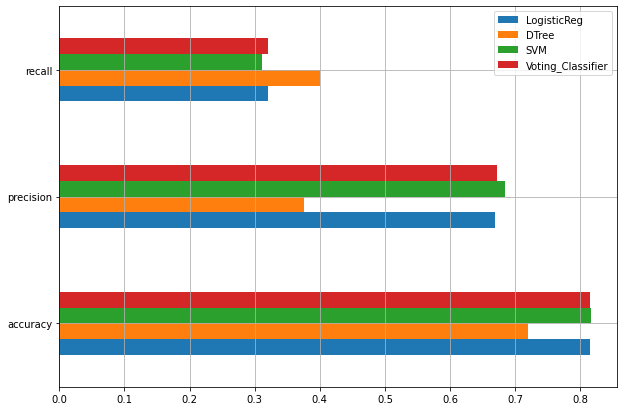

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
metrics.plot(kind='barh', ax=ax)
ax.grid()


In [24]:

precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_true=y_test, probas_pred=LogisticReg.predict_proba(X_test)[:, 1])

precision_dt, recall_dt, thresholds_dt = precision_recall_curve(
    y_true=y_test, probas_pred=DTree.predict_proba(X_test)[:, 1])

precision_vc, recall_vc, thresholds_vc = precision_recall_curve(
    y_true=y_test, probas_pred=pred_test_VC)

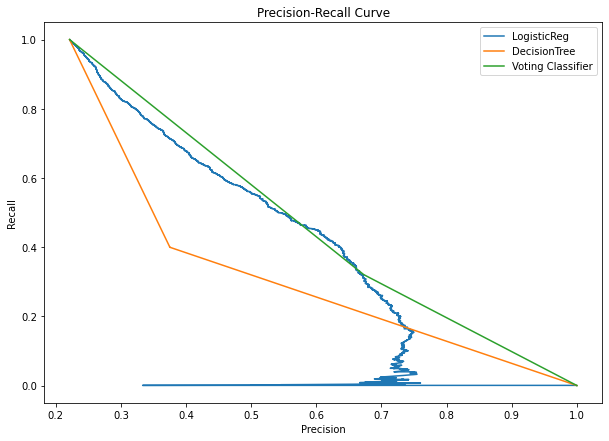

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.plot(precision_dt, recall_dt, label='DecisionTree')
ax.plot(precision_vc, recall_vc, label='Voting Classifier')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.legend()

plt.show()

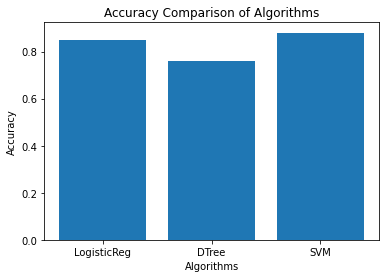

In [26]:
import matplotlib.pyplot as plt

# Sample data for algorithm names and accuracy values
algorithm_names = ['LogisticReg', 'DTree', 'SVM']
accuracy_values = [0.85, 0.76, 0.88]

# Create a bar chart
plt.bar(algorithm_names, accuracy_values)

# Set the title and labels for the chart
plt.title('Accuracy Comparison of Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')

# Display the chart
plt.show()

